<a href="https://colab.research.google.com/github/szchen01/Synthetic-Promoter-Data-CNN/blob/main/synthetic_promoter_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.functional import Tensor
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import math

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [ ]:
def set_seed(seed: int = 32) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set as {seed}")

set_seed(10)

Random seed set as 10


# 1. Generate Data

## Define

In [ ]:
bases = ['A', 'T', 'C', 'G']
motifs1 = ['TAT', 'CTG', 'GCGG', 'GATTACA', 'ACC']
motifs2 = ['TAT', 'CTG', 'GCG']
motifs_simple = ['GATTACA']
motifs_simple2 = ['TAT']
score_dict = {
    'TAT':15,
    'CTG':12,
    'GCG':15,
    'GCGG':7,
    'GATTACA':20,
    'ACC':10,
    'TAG':-25,
    'TGA':-25
}

In [ ]:
def count_motif_occurrences(string, motif):
    count = 0
    start = 0

    while True:
        # Find the index of the next occurrence of the motif
        index = string.find(motif, start)

        # If the motif is not found, break the loop
        if index == -1:
            break

        # Increment the count and update the start index for the next search
        count += 1
        start = index + 1

    return count

In [ ]:
motifs = motifs2

def generate_data(quantity, length, motifs, motif_freq=0.01):
  seqs, labels = [], []
  # longest_motif = max(len(mot) for mot in motifs)
  for _ in range(quantity):
    seq = ''
    seq_score = 0.0

    while len(seq) < length:
      p = np.random.uniform(0, 1)
      if p <  motif_freq:
        motif = np.random.choice(motifs)
        if len(motif) + len(seq) <= length:
          seq += motif
          # seq_score += score_dict[motif]
      else:
        rand_base = np.random.choice(bases)
        seq += rand_base
    seqs.append(seq)
    for motif in motifs:
      motif_count = count_motif_occurrences(seq, motif)
      seq_score += motif_count * score_dict[motif]
    labels.append(seq_score)
  return seqs, labels

Xraw, Yraw = generate_data(60000, 8, motifs, motif_freq=0.1)

print(f'quantity: {len(Xraw)} length: {len(Xraw[0])}')
print(len(Yraw))

quantity: 60000 length: 8
60000


In [ ]:
def normalize(Y):
  # normalize labels to have mean 0 and variance 1
  mean, std, var = torch.mean(Y), torch.std(Y), torch.var(Y)
  Y = (Y-mean)/std
  print(f'mean: {torch.mean(Y)}, std: {torch.std(Y)}, var: {torch.var(Y)}')
  return Y

Yraw = Tensor(Yraw)
Y = normalize(Yraw)
Y = Y.view(-1, 1, 1)
Y.shape

mean: -1.3732909920349812e-08, std: 0.9999999403953552, var: 0.9999998807907104


torch.Size([60000, 1, 1])

In [ ]:
# char to int conversion dictionaries
btoi = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
itob = {i:b for b,i in btoi.items()}
def enc(X):
  # convert X from strings to numbers then one hot encode
  X_enc = []
  for seq in X:
    temp = []
    for b in seq:
      i = btoi[b]
      temp.append(i)
    X_enc.append(temp)
  X_enc = Tensor(X_enc)
  X_enc = F.one_hot(X_enc.to(torch.int64), num_classes = 4)
  X_enc = torch.permute(X_enc, (0, 2, 1))
  X_enc = X_enc.float()
  print(X_enc.shape)
  return X_enc
X = enc(Xraw)


torch.Size([60000, 4, 8])


In [ ]:
def gen_all(quantity=None, length=None, motifs=None, motif_freq=0.01):
  X, Y = generate_data(quantity, length, motifs, motif_freq)
  Y = Tensor(Y)
  Y = normalize(Y)
  Y = Y.view(-1, 1, 1)
  X = enc(X)
  return X, Y

## Instance

In [ ]:
X2, Y2 = gen_all(
                 quantity=10000,
                 length=25,
                 motifs=motifs2,
                 )
X250, Y250 = gen_all(
                 quantity=1000,
                 length=250,
                 motifs=motifs2,
                 )

mean: -4.959106458812812e-09, std: 1.0, var: 1.0000001192092896
torch.Size([10000, 4, 25])
mean: -8.201599399626502e-08, std: 1.0, var: 0.9999999403953552
torch.Size([1000, 4, 250])


## Sanity check tests

(array([2.3903e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.8390e+03, 0.0000e+00,
        0.0000e+00, 1.8152e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 6.5000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2510e+03, 0.0000e+00, 0.0000e+00, 3.8270e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+01, 0.0000e+00,
        0.0000e+00, 1.6600e+02, 0.0000e+00, 0.0000e+00, 1.9200e+02]),
 array([ 0.        ,  0.89999998,  1.79999995,  2.70000005,  3.5999999 ,
         4.5       ,  5.4000001 ,  6.30000019,  7.19999981,  8.10000038,
         9.        ,  9.89999962, 10.80000019, 11.69999981, 12.60000038,
        13.5       , 14.39999962, 15.30000019, 16.20000076, 17.10000038,
        18.        , 18.89

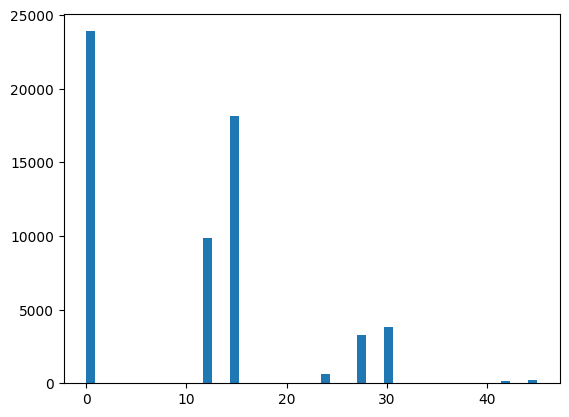

In [ ]:
plt.hist(Yraw, bins=50)

In [ ]:
# Y_np = Y.numpy()
# plt.hist(Y_np, bins=50)

In [ ]:
print(all([len(seq)==8 for seq in Xraw]))
print(len(Xraw))
print(len(Yraw))
print(all([Yraw[i]==1.0 for i in range(len(Xraw)) if 'TAT' in Xraw[i]]))
print(all([Yraw[i]==0.0 for i in range(len(Xraw)) if 'TAT' not in Xraw[i]]))
# for i in range(len(Xraw)):
#   if 'TAT' in Xraw[i]:
#     if Yraw[i]!=1.0:
#       print(Xraw[i], Yraw[i])



True
60000
60000
False
False


# 2. Building Datasets and Dataloaders + Encoding Data

## Sequence Datasets + DLs

In [ ]:
class SeqDatasetOHE(Dataset):
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):

        self.ohe_seqs = df[0]
        self.seq_len = len(self.ohe_seqs[0])
        self.labels = df[1].unsqueeze(1)

    def __len__(self): return len(self.ohe_seqs)

    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]

        return seq, label
def build_dataset(X, Y):
  n1 = int(0.8*len(X))
  n2 = int(0.9*len(X))
  Xtr = X[:n1]
  Ytr = Y[:n1]
  Xdev = X[n1:n2]
  Ydev = Y[n1:n2]
  Xte = X[n2:]
  Yte = Y[n2:]
  return (Xtr, Ytr), (Xdev, Ydev), (Xte, Yte)

#data loaders
def build_dataloaders(trainData,
                      valData,
                      testData,
                      batch_size = 200
                      ):

  train_dl = DataLoader(trainData, batch_size=batch_size)
  val_dl = DataLoader(valData, batch_size=batch_size)

  return train_dl, val_dl

In [ ]:
def build_all(X, Y):
  train_df, val_df, test_df = build_dataset(X, Y)

  train_ds = SeqDatasetOHE(train_df,seq_col='seq',target_col='score')
  val_ds = SeqDatasetOHE(val_df,seq_col='seq',target_col='score')
  test_ds = SeqDatasetOHE(test_df,seq_col='seq',target_col='score')

  train_dl, val_dl = build_dataloaders(train_ds, val_ds, test_ds)
  return train_dl, val_dl

## Instance

In [ ]:
# train_df, val_df, test_df = build_dataset(X, Y)

# train_ds1 = SeqDatasetOHE(train_df,seq_col='seq',target_col='score')
# val_ds1 = SeqDatasetOHE(val_df,seq_col='seq',target_col='score')
# test_ds1 = SeqDatasetOHE(test_df,seq_col='seq',target_col='score')
#
# dl1 is 1 motif 8 len
# tr_dl1, val_dl1 = build_all(X, Y)
# dl2 is 3 motif 8 len
tr_dl2, val_dl2 = build_all(X, Y)
# dl3 is 3 motif 25 len
tr_dl3, val_dl3 = build_all(X2, Y2)
tr_dl4, val_dl4 = build_all(X250, Y250)

## sanity check

In [ ]:
for xb, yb in tr_dl2:
  decoded_xb = torch.argmax(xb, dim=1)
  strings = []
  for seq in decoded_xb:
    seq_str = ''
    for base in seq:
      base = base.item()
      seq_str += itob[base]
    strings.append(seq_str)
  ys = []
  for item in yb:
    item = item.item()
    ys.append(item)
  testzips = zip(strings, ys)
  assert all([tup[1] != 0 for tup in testzips if tup[0] == 'TAT']), 'data is wrongly labelled'
  assert all([tup[0] != 'TAT' for tup in testzips if tup[1] != 1])
  assert all([tup[0] == 'TAT' for tup in testzips if tup[1] == 1])

# 3. Define Training Functions

In [ ]:
import torch.optim as optim

def loss_batch(model=None, xb=None, yb=None, loss_func=None, opt=None, verbose=False, device=None, reg=None, lamb=None):
  # if no optimizer provided, skip backprop
  xb_out = model(xb)
  # print(yb.shape)
  yb = torch.flatten(yb, 1)
  # print(yb.shape)

  if reg:
    if not lamb:
      lamb = 0.001
    # l1_reg = Tensor(0)
    # for param in model.parameters():
    #   l1_reg += lamb * abs(param)

    loss = loss_func(xb_out, yb) + reg(model.parameters(), lamb)
  else:
    loss = loss_func(xb_out, yb)

  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

def train_step(model=None, train_dl=None, loss_func=None, opt=None, device=None, reg=None, lamb=None):
  model.train()
  tl = [] # training losses
  ns = [] # batch sizes

  for xb, yb in train_dl:
    xb, yb = xb.to(device), yb.to(device)
    t, n = loss_batch(model, xb, yb, loss_func, opt = opt, device=device, reg=reg, lamb=lamb)
    tl.append(t)
    ns.append(n)

  # train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
  train_loss = tl[-1]


  return train_loss

def val_step(model=None, val_dl=None, loss_func=None, device=None):
  model.eval()
  with torch.no_grad():
    vl = []
    ns = []

    for xb, yb in val_dl:
      xb, yb = xb.to(device), yb.to(device)
      v, n = loss_batch(model, xb, yb, loss_func, device=device)
      vl.append(v)
      ns.append(n)

  # val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
  val_loss = vl[-1]

  return val_loss

def fit(epochs=None, model=None, loss_func=None, opt=None, train_dl=None, val_dl=None, device=None, reg=None, lamb=None):
  train_losses = []
  val_losses = []
  print(opt)
  for epoch in range(epochs):
    train_loss = train_step(model, train_dl, loss_func, opt, device=device, reg=reg, lamb=lamb)
    train_losses.append(train_loss)
    val_loss = val_step(model=model, val_dl=val_dl, loss_func=loss_func, device=device)
    val_losses.append(val_loss)

    print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

  return train_losses, val_losses

def run(train_dl=None, val_dl=None, model=None, lr=0.01, epochs = 100, loss_func=None, opt=None, device=None, reg=None, lamb=None):
  if not opt:
    opt = optim.Adam(model.parameters(), lr=lr)
  if not loss_func:
    loss_func = nn.MSELoss()

  train_losses, val_losses = fit(epochs,
                     model,
                     loss_func,
                     opt,
                     train_dl,
                     val_dl,
                     device=device,
                     reg=reg,
                     lamb=lamb
                     )
  return train_losses, val_losses


In [ ]:
def l1_reg(params, l1_lambda):
  l1_norm = sum(p.abs().sum() for p in params)
  return l1_lambda*l1_norm

# 4. CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,
                 seq_length,
                 num_filters = 32,
                 kernel_size = 7,
                 pool_size = 12,
                 pool_stride = 4,
                 ):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
          nn.Conv1d(4, num_filters, kernel_size=kernel_size),
          # nn.ReLU(),
          # nn.Dropout(p=0.5),

          torch.nn.Flatten(),

          # nn.MaxPool1d(kernel_size=num_filters*(seq_length-kernel_size + 1) // 2, stride=num_filters*(seq_length-kernel_size + 1) // 4),
          nn.MaxPool1d(pool_size, pool_stride),
          # nn.MaxPool1d(num_filters*(seq_length-kernel_size + 1)),

          nn.Linear(math.floor(((num_filters*(seq_length-kernel_size + 1) - pool_size) / pool_stride) + 1), 1),
          # nn.ReLU(),
          # nn.Sigmoid()
        )

        with torch.no_grad():
          self.model[0].weight *= 0.1


        # self.loss = nn.MSELoss()
        # self.conv = nn.Conv1d(4, 32, kernel_size, stride=1, padding=1)
        # self.relu = nn.ReLU()
        # self.maxpool = nn.MaxPool1d(length - kernel_size + 2)
        # self.flatten = torch.nn.Flatten(1)
        # self.fc = nn.Linear(32, 1)
        # self.fctest1 = nn.Linear(28, 100)
        # self.fctest2 = nn.Linear(100, 1)
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model_cnn1 = ConvNet(seq_length=8, kernel_size=3, num_filters=3)
opt = optim.Adam(model_cnn1.parameters(), lr=0.001)
# opt = optim.SGD(model_cnn1.parameters(), lr=0.25)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# run the model
model_cnn1.to(DEVICE)
cnn_train_losses, cnn_val_losses = run(
    tr_dl1,
    val_dl1,
    model_cnn1,
    opt = opt,
    device = DEVICE,
    epochs = 400,
    reg=l1_reg,
    lamb=0.01
)

NameError: ignored

In [ ]:
model_cnn2 = ConvNet(seq_length=8, kernel_size=3, num_filters=32)
opt = optim.Adam(model_cnn2.parameters(), lr=0.01)
# opt = optim.SGD(model_cnn.parameters(), lr=0.25)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# run the model
model_cnn2.to(DEVICE)
cnn_train_losses, cnn_val_losses = run(
    tr_dl2,
    val_dl2,
    model_cnn2,
    opt = opt,
    device = DEVICE,
    epochs = 400,
    reg=l1_reg,
    lamb=0.0001
)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
E0 | train loss: 0.081 | val loss: 0.095
E1 | train loss: 0.059 | val loss: 0.066
E2 | train loss: 0.052 | val loss: 0.054
E3 | train loss: 0.050 | val loss: 0.049
E4 | train loss: 0.050 | val loss: 0.043
E5 | train loss: 0.047 | val loss: 0.045
E6 | train loss: 0.042 | val loss: 0.038
E7 | train loss: 0.038 | val loss: 0.038
E8 | train loss: 0.035 | val loss: 0.039
E9 | train loss: 0.034 | val loss: 0.039


KeyboardInterrupt: ignored

In [ ]:
model_cnn3 = ConvNet(seq_length=25, kernel_size=3, num_filters=10)
opt = optim.Adam(model_cnn3.parameters(), lr=0.01)
# opt = optim.SGD(model_cnn.parameters(), lr=0.25)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# run the model
model_cnn3.to(DEVICE)
cnn_train_losses, cnn_val_losses = run(
    tr_dl3,
    val_dl3,
    model_cnn3,
    opt = opt,
    device = DEVICE,
    epochs = 400,
    reg=l1_reg,
    lamb=0.0001
)

In [ ]:
model_cnn4 = ConvNet(seq_length=250, kernel_size=3, num_filters=32)
opt = optim.Adam(model_cnn4.parameters(), lr=0.001)
# opt = optim.SGD(model_cnn.parameters(), lr=0.25)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)
# run the model
model_cnn4.to(DEVICE)
cnn_train_losses, cnn_val_losses = run(
    tr_dl4,
    val_dl4,
    model_cnn4,
    opt = opt,
    device = DEVICE,
    epochs = 1000,
    # reg=l1_reg,
    # lamb=0.0001
)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
E0 | train loss: 1.326 | val loss: 1.004
E1 | train loss: 1.307 | val loss: 0.995
E2 | train loss: 1.289 | val loss: 0.986
E3 | train loss: 1.272 | val loss: 0.979
E4 | train loss: 1.256 | val loss: 0.972
E5 | train loss: 1.241 | val loss: 0.966
E6 | train loss: 1.226 | val loss: 0.960
E7 | train loss: 1.213 | val loss: 0.956
E8 | train loss: 1.200 | val loss: 0.952
E9 | train loss: 1.189 | val loss: 0.948
E10 | train loss: 1.179 | val loss: 0.946
E11 | train loss: 1.169 | val loss: 0.944
E12 | train loss: 1.160 | val loss: 0.942
E13 | train loss: 1.152 | val loss: 0.941
E14 | train loss: 1.145 | val loss: 0.941
E15 | train loss: 1.139 | val loss: 0.941
E16 | train loss: 1.133 | val loss: 0.941
E17 | train loss: 1.128 | val loss: 0.941
E18 | train loss: 1.124 | val lo

KeyboardInterrupt: ignored

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model_cnn4, (4, 250))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 248]             416
           Flatten-2                 [-1, 7936]               0
         MaxPool1d-3                 [-1, 1982]               0
            Linear-4                    [-1, 1]           1,983
           Sigmoid-5                    [-1, 1]               0
Total params: 2,399
Trainable params: 2,399
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.01
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


## Grid Search

In [ ]:
lrs = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]
lambs = [0.5, 0.1, 0.01, 0.001, 0.0001]
lr_losses = []
for lr in lrs:
  for lamb in lambs:
    print(f'------{lr}:{lamb}------')
    repeat_lr = lr
    repeats = 1
    for i in range(repeats):
      temp_model_cnn = ConvNet(seq_length=8)
      opt = optim.Adam(temp_model_cnn.parameters(), lr=repeat_lr)
      temp_model_cnn.to(DEVICE)
      test_lr_loss = run(
          tr_dl2,
          val_dl2,
          temp_model_cnn,
          opt = opt,
          epochs = 25
      )
      lr_losses.append(test_lr_loss)

## Learning rate testing

In [ ]:
lrs = [0.5, 0.25, 0.1, 0.05, 0.025, 0.01]
lr_losses = []
for lr in lrs:
  print(f'------{lr}------')
  repeat_lr = lr
  repeats = 5
  for i in range(repeats):
    print(f'------{repeat_lr}------')
    model_cnn = ConvNet(seq_length=250)
    opt = optim.Adam(model_cnn.parameters(), lr=repeat_lr)
    test_lr_loss = run(
        xTr_dl,
        xVal_dl,
        model_cnn,
        opt = opt,
        epochs = 25
    )
    lr_losses.append(test_lr_loss)

In [ ]:
repeat_lr = 0.25
repeats = 10
lr_losses = []
for i in range(repeats):
  print(f'------{repeat_lr}------')
  model_cnn = ConvNet(seq_length=250)
  opt = optim.Adam(model_cnn.parameters(), lr=repeat_lr)
  test_lr_loss = run(
      xTr_dl,
      xVal_dl,
      model_cnn,
      opt = opt,
      epochs = 25
  )
  lr_losses.append(test_lr_loss)

In [ ]:
for i in range(4):

  plt.plot(lr_losses[i])
plt.legend()

In [ ]:
for i in range(len(lrs)):
  for i in range(repeats):
    plt.plot(lr_losses[i], label=lrs[i])
plt.legend(lr_losses, lrs)

In [ ]:
for curve in lr_losses:
  plt.plot(curve)

In [ ]:
for lr in lrs:
  for i in range(repeats):


# 5. Defining and Running Linear Model

## Linear Model

In [ ]:
class LinearNet(nn.Module):
    def __init__(self, seq_length):
      super().__init__()
      self.seq_length = seq_length
      self.flatten = nn.Flatten(1)
      self.lin1 = nn.Linear(seq_length * 4, 100, bias=True)
      # self.lin2 = nn.Linear(100, 1)
      self.sig = nn.Sigmoid()
    def forward(self, x):

      x = self.flatten(x)
      # x = x.view(x.shape[0], -1, 1)
      # print(x.shape)
      # print(x)
      x = self.lin1(x)
      # x = self.sig(x)
      # x = self.lin2(x)

      # x = self.tanh(x)
      # print(x.shape)
      return x



## Run

In [ ]:
model_lin_250 = LinearNet(seq_length=250)
lin_250_losses = run(xTr_dl,
                     xVal_dl,
                     model_lin_250,
                     lr = 0.0001
                     )

# 6. Model Examples

In [ ]:
def quick_examples(model, dataloader):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    '''
    outs = []
    yis = []
    for x, y in dataloader:
      for i in range(10):
        xi = x[i].view(1, x[i].shape[0], x[i].shape[1])
        out = model(xi)
        print(f'predicted:{out} --> actual:{y[i]}')
        outs.append(out.item())
        yis.append(y[i].item())
    return outs, yis

In [ ]:
examples = quick_examples(model_cnn2, tr_dl2)

NameError: ignored

In [ ]:
plt.scatter(examples[0], examples[1])
plt.xlabel('predicted')
plt.ylabel('labels')

# 7. Visualize Filters

In [ ]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())

    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if isinstance(model_children[i], torch.nn.Conv1d):
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif isinstance(model_children[i], torch.nn.Sequential):
            for child in model_children[i]:
                if isinstance(child, torch.nn.Conv1d):
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)
    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))

    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))
    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

Total convolutional layers: 1


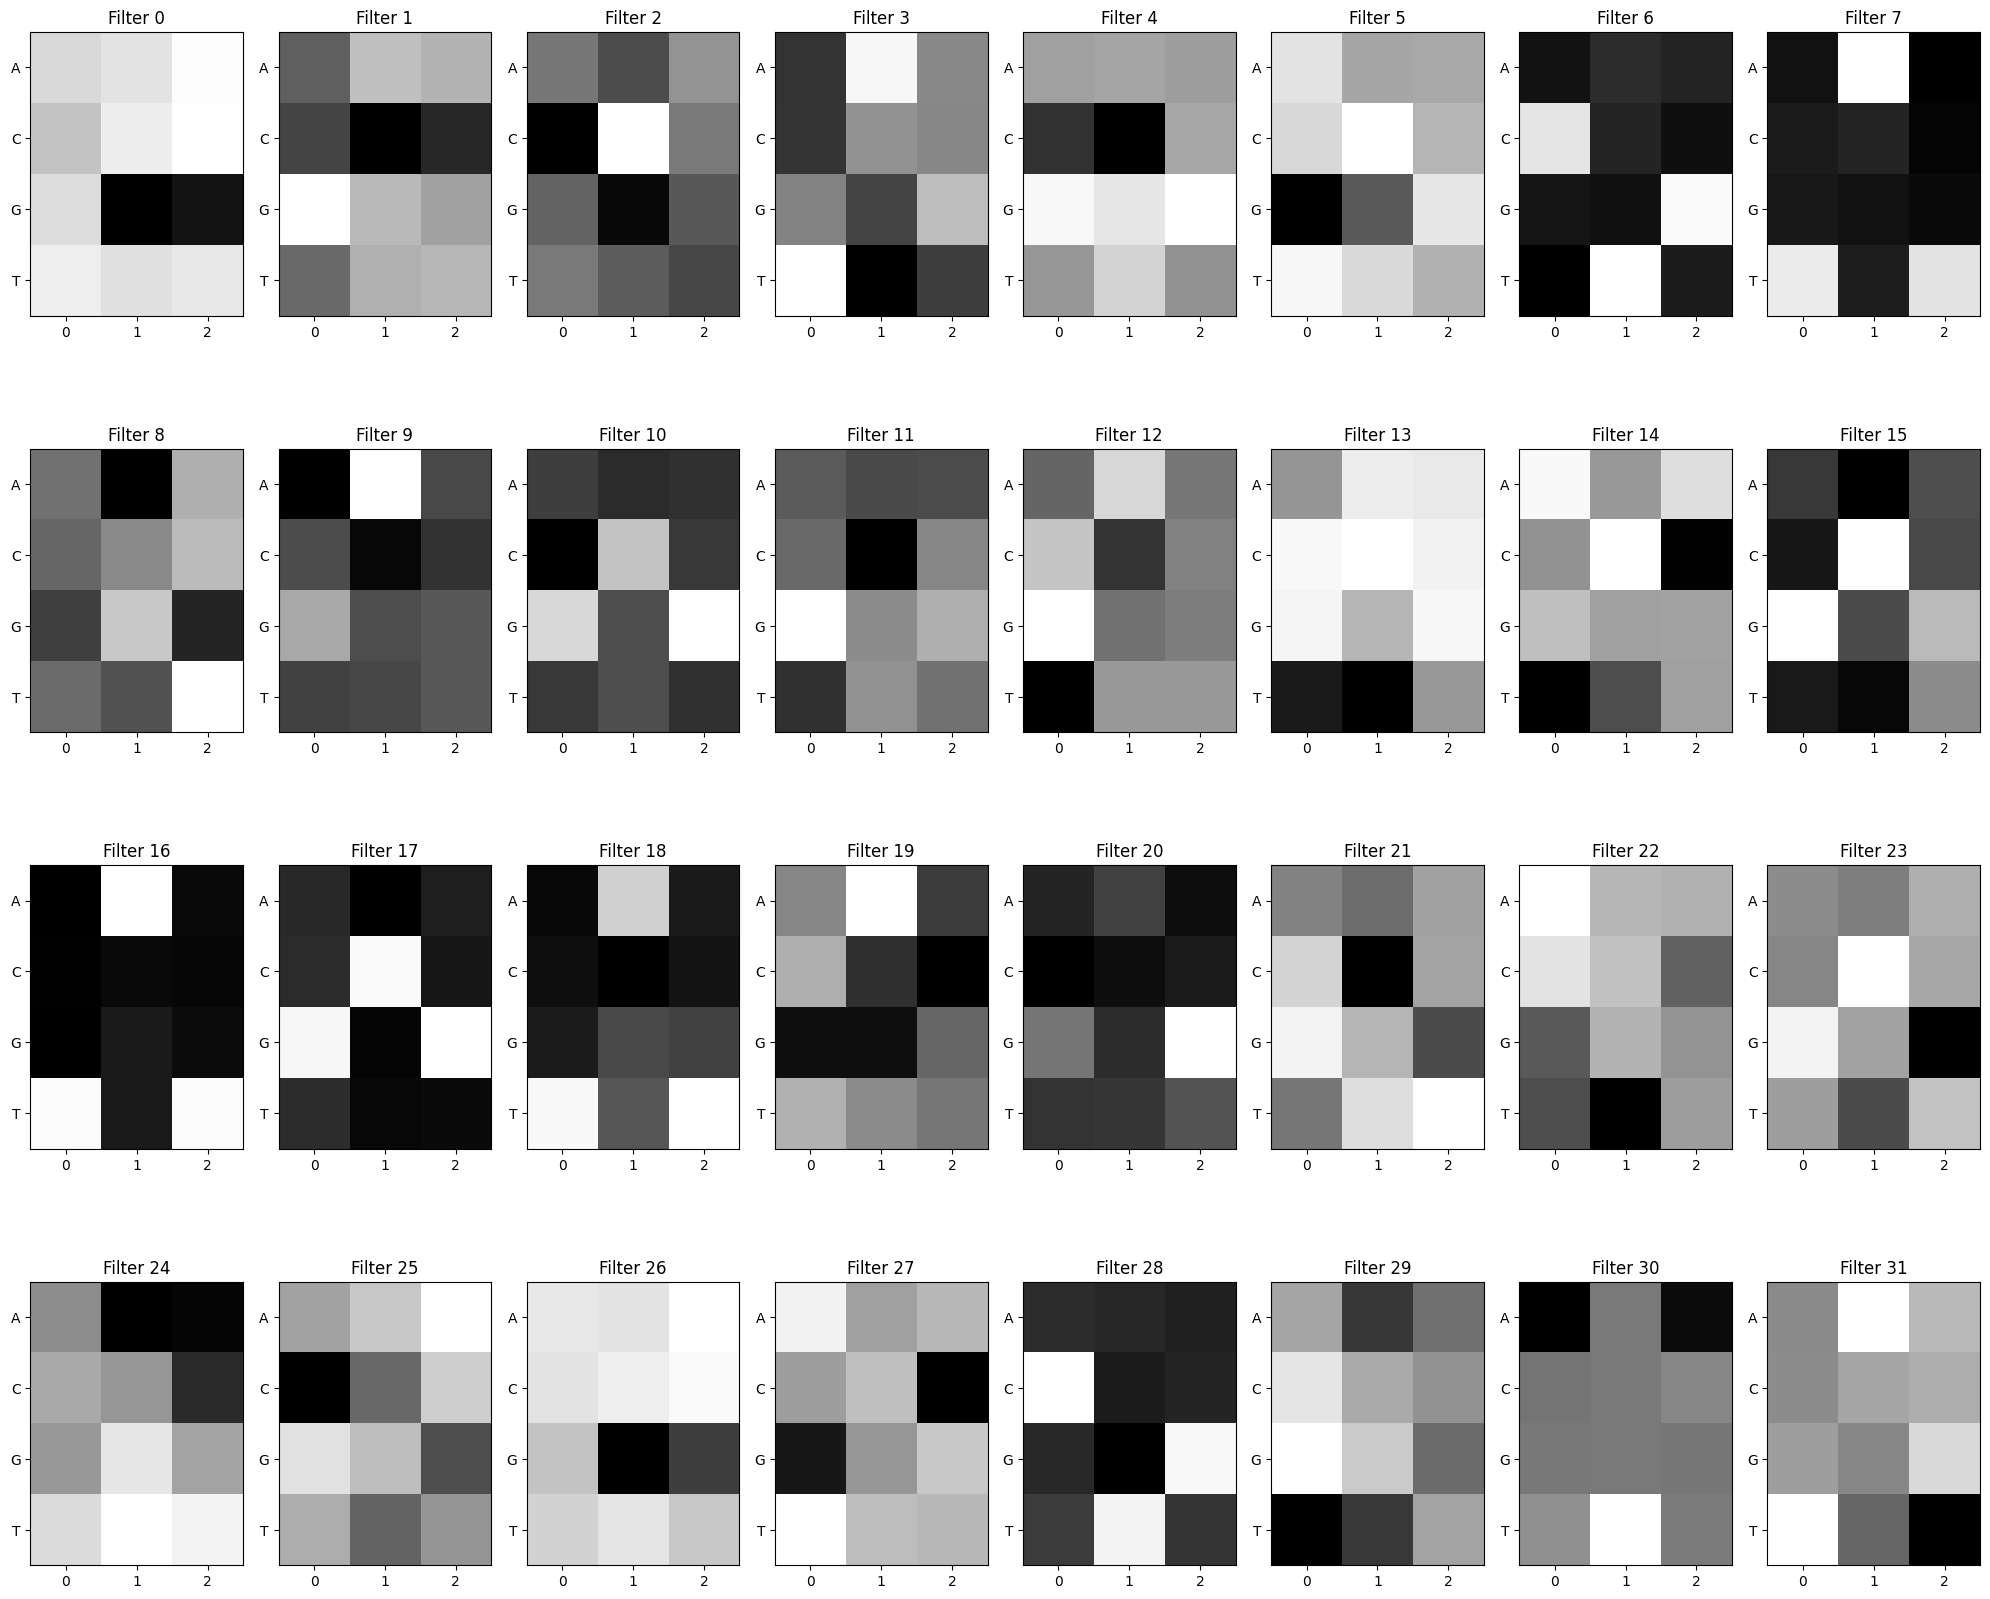

In [ ]:
model_to_visualize = model_cnn2

conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_to_visualize)
view_filters(model_weights)

In [ ]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn3)
view_filters(model_weights)

Total convolutional layers: 1


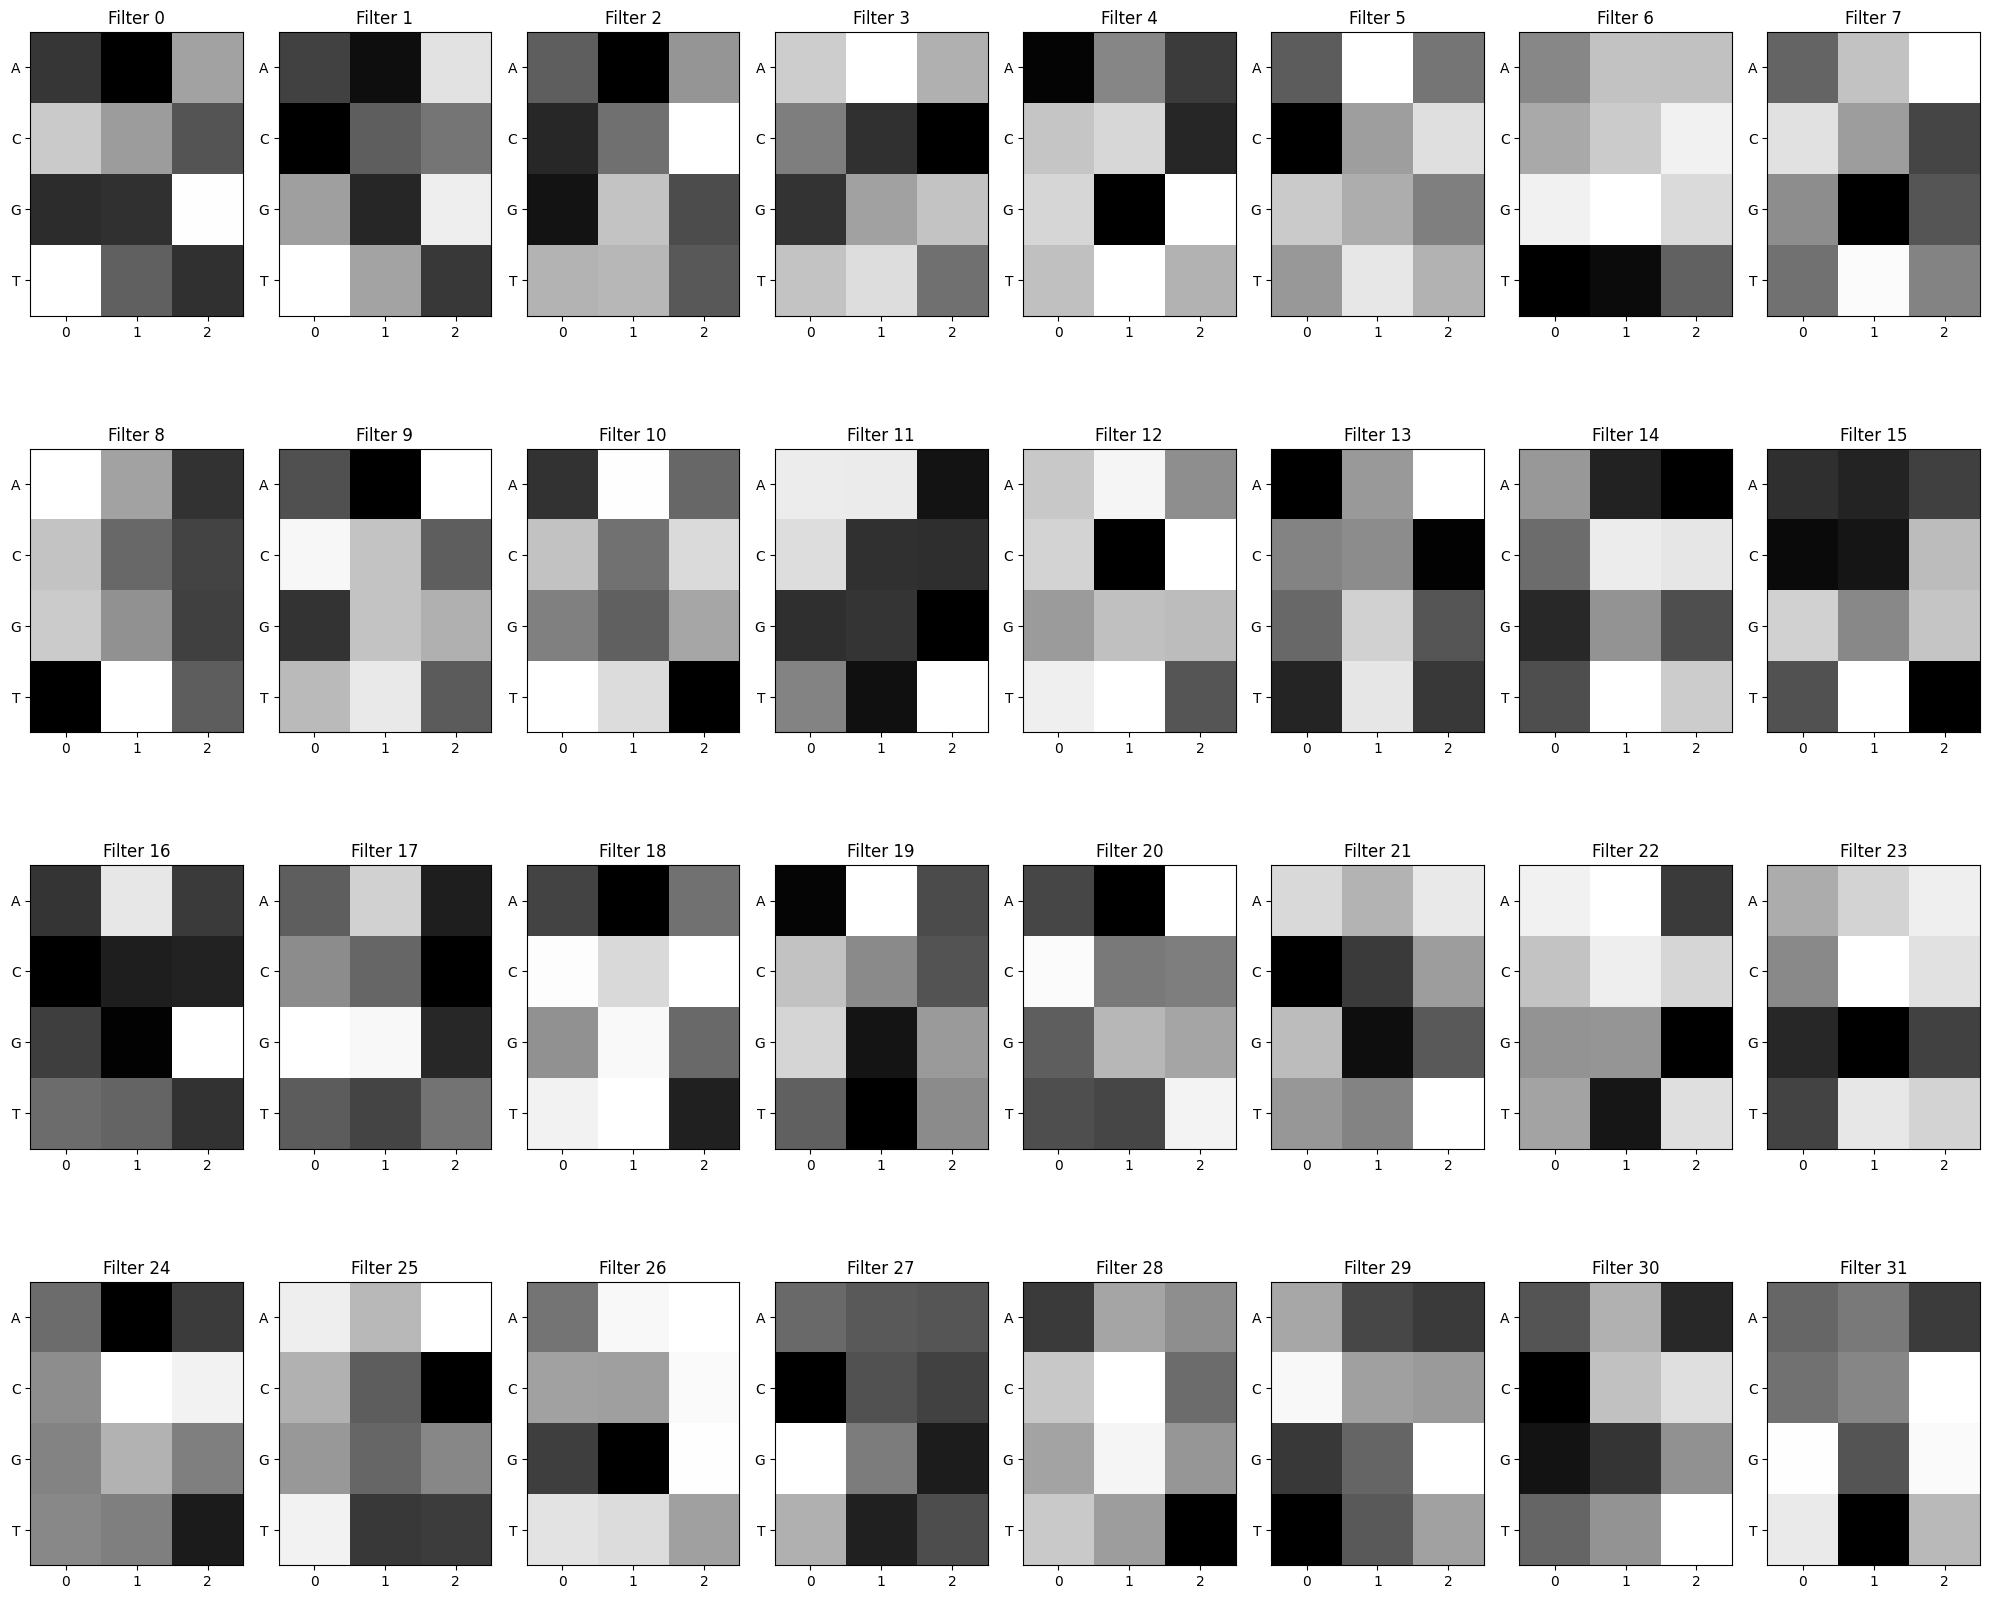

In [ ]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn4)
view_filters(model_weights)

# Crap Code

In [ ]:
#optimization
import torch.optim as optim

steps = 10000
lossi = []
batch_size = 100
Xin = sXenc
Yin = sYtr
# lr = 0.001
loss = nn.MSELoss()
linear = LinearNet(7)
net = linear
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

for i in range(steps):

  #batch construct
  ix = torch.randint(0, Xin.shape[0], (batch_size,))
  Xb, Yb = Xin[ix], Yin[ix]

  #forward pass
  output = net(Xb)
  loss_v = loss(output, Yb)
  lossi.append(loss_v.item())

  #backward pass
  loss_v.backward()
  optimizer.step()
  optimizer.zero_grad()



  if i % 100 == 0: # print every once in a while
    print(f'{i:7d}/{steps:7d}: {loss_v.item():.4f}')


In [ ]:
Ytr.shape

In [ ]:
Xdev = enc(Xdev)
Xte = enc(Xte)

@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xenc, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  loss = net(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
sXenc.shape

In [ ]:
shapes = []
testxi = torch.reshape(sXenc[10], (1, 4, -1))
net(testxi)
shapestr = ''
# for shape in shapes:
#   shapestr += f'{shapes}---> '
shapestr

In [ ]:
for x, y in sxTr_dl:
  for i in range(50):
    xi = x[i].view(1, x[i].shape[0], x[i].shape[1])
    print(f'{model_lin(xi)} --> {y[i]}')

In [ ]:
shapes

In [ ]:
for seqs, labs in sxTr_dl:
  # print(f'seqs: {seqs[0]}')
  x_again = torch.argmax(seqs, dim=1)
  # print(f'x_again: {x_again[0]}')
strings = []
for x in x_again:
  # print(f'x: {x}')
  x_str = ''
  for i in x:
    i = i.item()
    x_str += itob[i]
  strings.append(x_str)
  # print(f'x_str: {x_str}')
# print(f'strings: {strings}')
ys = []
for item in labs:
  item = item.item()
  ys.append(item)

testzips = zip(strings, ys)

print(all([tup[1] == 0 for tup in testzips if tup[0] != gat]))
print(all([tup[1] == 1 for tup in testzips if tup[0] == gat]))
print(list(testzips))